In [3]:

import torch
from flextok.flextok_wrapper import FlexTokFromHub
from diffusers.models import AutoencoderKL
from flextok.utils.demo import imgs_from_urls
import matplotlib.pyplot as plt
from reconstruction_loss import reconstruction_error

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# this model contains the VAE and the denoiser
model = FlexTokFromHub.from_pretrained('EPFL-VILAB/flextok_d18_d28_in1k').eval().to(device)


In [4]:
from data.utils.dataloaders import get_imagenet_dataloader
imgnet_dataloader = get_imagenet_dataloader(batch_size=32)

/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 64 worker processes in total. Our suggested max number of worker in current system is 20, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [5]:
first_images, first_labels = next(iter(imgnet_dataloader))

In [6]:
def reconstructionLoss_vs_compressionRate(model, images, k_keep_list, loss_fns, loss_weights=None):
    """
    Computes reconstruction losses for different compression rates.
    
    Args:
        model: FlexTok model instance.
        images: Tensor of shape (B, 3, H, W) with input images.
        k_keep_list: List of integers representing the number of tokens to keep.
        loss_fns: List of loss functions to compute.
        loss_weights: List of weights for each loss function.
    
    Returns:
        dict: Dictionary with compression rates as keys and total losses as values.
    """
    results = {}
    
    # First tokenize the images into register tokens, which already handles the VAE mapping to latents.
    tokens_list = model.tokenize(images.to(device))

    # we want to see how the reconstruction error changes with different compression rates.
    # lower k_keep means (fewer registers) more compression, higher k_keep means less compression.
    for k_keep in k_keep_list:
        # the first ":" means for all images in the batch, the second refers to the register tokens.
        # we keep only the first k_keep tokens.
        tokens_list_filtered = [t[:,:k_keep] for t in tokens_list]
        
        reconst = model.detokenize(
            tokens_list_filtered,
            timesteps=20,
            guidance_scale=7.5,
            perform_norm_guidance=True,
        )
        
        total_loss, loss_dict = reconstruction_error(reconst, images, 
            loss_fns=loss_fns,
            loss_weights=loss_weights
        )
        print(f"Compression rate k_keep={k_keep}: Total Loss = {loss_dict.values()}")
        
        results[k_keep] = loss_dict
    
    return results

In [8]:
from reconstruction_loss import MAELoss, VGGPerceptualLoss


k_keep_list = [1, 4, 8, 16, 32, 64, 128, 200, 256]  # Different compression rates to test
loss_fns = [VGGPerceptualLoss().to(device), MAELoss()]
results = reconstructionLoss_vs_compressionRate(model, first_images.to(device), k_keep_list, loss_fns, loss_weights=None)

/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20/20 [01:45<00:00,  5.30s/it]


Compression rate k_keep=1: Total Loss = dict_values([6.551492691040039, 1.007537841796875])


100%|██████████| 20/20 [01:46<00:00,  5.35s/it]


Compression rate k_keep=4: Total Loss = dict_values([6.452919960021973, 0.8183573484420776])


100%|██████████| 20/20 [01:48<00:00,  5.42s/it]


Compression rate k_keep=8: Total Loss = dict_values([6.328386306762695, 0.8001121282577515])


100%|██████████| 20/20 [01:49<00:00,  5.46s/it]


Compression rate k_keep=16: Total Loss = dict_values([6.416606426239014, 0.7406759262084961])


100%|██████████| 20/20 [01:46<00:00,  5.34s/it]


Compression rate k_keep=32: Total Loss = dict_values([6.438834190368652, 0.7039017081260681])


100%|██████████| 20/20 [01:46<00:00,  5.31s/it]


Compression rate k_keep=64: Total Loss = dict_values([6.307858943939209, 0.6801621913909912])


100%|██████████| 20/20 [01:46<00:00,  5.34s/it]


Compression rate k_keep=128: Total Loss = dict_values([5.713963985443115, 0.6016665101051331])


100%|██████████| 20/20 [01:47<00:00,  5.36s/it]


Compression rate k_keep=200: Total Loss = dict_values([5.429396629333496, 0.5616083145141602])


100%|██████████| 20/20 [01:47<00:00,  5.37s/it]


Compression rate k_keep=256: Total Loss = dict_values([5.173590183258057, 0.5463761687278748])


Results: {1: {'VGGPerceptualLoss': 6.551492691040039, 'MAELoss': 1.007537841796875}, 4: {'VGGPerceptualLoss': 6.452919960021973, 'MAELoss': 0.8183573484420776}, 8: {'VGGPerceptualLoss': 6.328386306762695, 'MAELoss': 0.8001121282577515}, 16: {'VGGPerceptualLoss': 6.416606426239014, 'MAELoss': 0.7406759262084961}, 32: {'VGGPerceptualLoss': 6.438834190368652, 'MAELoss': 0.7039017081260681}, 64: {'VGGPerceptualLoss': 6.307858943939209, 'MAELoss': 0.6801621913909912}, 128: {'VGGPerceptualLoss': 5.713963985443115, 'MAELoss': 0.6016665101051331}, 200: {'VGGPerceptualLoss': 5.429396629333496, 'MAELoss': 0.5616083145141602}, 256: {'VGGPerceptualLoss': 5.173590183258057, 'MAELoss': 0.5463761687278748}}


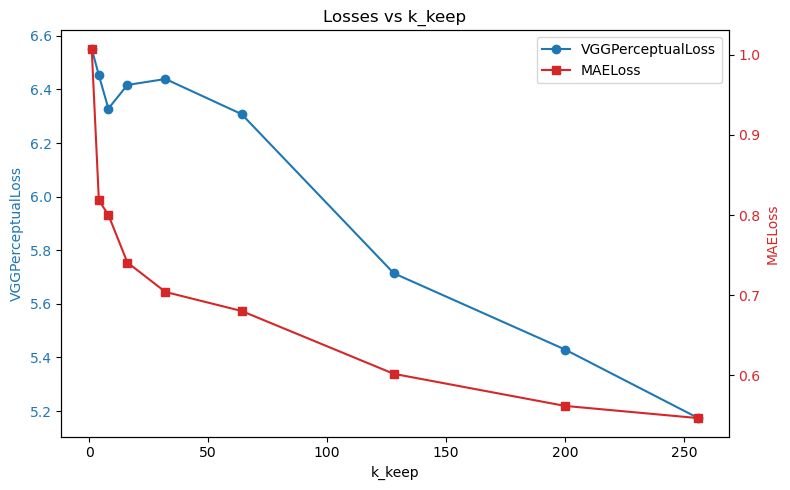

: 

In [ ]:
print("Results:", results)
import matplotlib.pyplot as plt

# Your data
results = {
    1:   {'VGGPerceptualLoss': 6.55149, 'MAELoss': 1.00754},
    4:   {'VGGPerceptualLoss': 6.45292, 'MAELoss': 0.81836},
    8:   {'VGGPerceptualLoss': 6.32839, 'MAELoss': 0.80011},
    16:  {'VGGPerceptualLoss': 6.41661, 'MAELoss': 0.74068},
    32:  {'VGGPerceptualLoss': 6.43883, 'MAELoss': 0.70390},
    64:  {'VGGPerceptualLoss': 6.30786, 'MAELoss': 0.68016},
    128: {'VGGPerceptualLoss': 5.71396, 'MAELoss': 0.60167},
    200: {'VGGPerceptualLoss': 5.42940, 'MAELoss': 0.56161},
    256: {'VGGPerceptualLoss': 5.17359, 'MAELoss': 0.54638},
}

# Prepare data lists
ks = sorted(results.keys())
vgg = [results[k]['VGGPerceptualLoss'] for k in ks]
mae = [results[k]['MAELoss']             for k in ks]

# Create plot
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(ks, vgg, color='tab:blue', marker='o', label='VGGPerceptualLoss')
ax1.set_xlabel('k_keep')
ax1.set_ylabel('VGGPerceptualLoss', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Twin axis for MAE Loss
ax2 = ax1.twinx()
ax2.plot(ks, mae, color='tab:red', marker='s', label='MAELoss')
ax2.set_ylabel('MAELoss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Optional: Add legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.title('Losses vs k_keep')
plt.tight_layout()
plt.show()
